In [1]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func, desc

import matplotlib
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

In [2]:
# Create engine using the `demographics.sqlite` database file
engine = create_engine("sqlite:///hawaii.sqlite")

In [3]:
# Use the Inspector to explore the database and print the table names
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [4]:
# Use Inspector to print the column names and types
print ("Measurent Column Names and Types")
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

print ("")

print ("Station Column Names and Types")
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

Measurent Column Names and Types
id INTEGER
station VARCHAR(128)
date VARCHAR(30)
prcp FLOAT
tobs FLOAT

Station Column Names and Types
id INTEGER
station VARCHAR(128)
name VARCHAR(128)
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [5]:
# Use `engine.execute` to select and display the first 10 rows from the measurement table
engine.execute('SELECT * FROM measurement LIMIT 10').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-07', 0.06, 70.0),
 (6, 'USC00519397', '2010-01-08', 0.0, 64.0),
 (7, 'USC00519397', '2010-01-09', 0.0, 68.0),
 (8, 'USC00519397', '2010-01-10', 0.0, 73.0),
 (9, 'USC00519397', '2010-01-11', 0.01, 64.0),
 (10, 'USC00519397', '2010-01-12', 0.0, 61.0)]

In [6]:
# Use `engine.execute` to select and display the first 10 rows from the station table
engine.execute('SELECT * FROM station LIMIT 10').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6),
 (6, 'USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5),
 (7, 'USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9),
 (8, 'USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9),
 (9, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)]

In [7]:
# Declare a Base using `automap_base()`
Base = automap_base()

# Use the Base class to reflect the database tables
Base.prepare(engine, reflect=True)

# Print all of the classes mapped to the Base
Base.classes.keys()

['measurement', 'station']

In [8]:
# List column names of measurement table
Base.classes.measurement.__table__.columns.keys()

['id', 'station', 'date', 'prcp', 'tobs']

In [9]:
# List column names of station table
Base.classes.station.__table__.columns.keys()

['id', 'station', 'name', 'latitude', 'longitude', 'elevation']

In [10]:
# Assign the measurement class to a variable called `Measurement`
Measurement = Base.classes.measurement

# Assign the measurement class to a variable called `Station`
Station = Base.classes.station

In [11]:
# Create a session
session = Session(engine)

In [12]:
# Use the session to query Measurement table and display the first 5 rows
for row in session.query(Measurement).limit(5).all():
    print(row.station, row.date, row.prcp, row.tobs)

USC00519397 2010-01-01 0.08 65.0
USC00519397 2010-01-02 0.0 63.0
USC00519397 2010-01-03 0.0 74.0
USC00519397 2010-01-04 0.0 76.0
USC00519397 2010-01-07 0.06 70.0


In [13]:
import datetime as dt

In [33]:
# Query for the precipitation for the last 12 months using the datetime library
# Parse out just the year, month, and day from the datetime object
qedate = '2017-8-23'
qsyear, qsmonth, qsday = map(int, qedate.split('-'))
qsdate = dt.date(qsyear, qsmonth, qsday) - dt.timedelta(days=365)
print("Query Start Date: ", qsdate)

Query Start Date:  2016-08-23


In [34]:
sel = [Measurement.date, 
      func.avg(Measurement.prcp)]

prcp_averages = session.query(*sel).\
    filter(Measurement.date >= qsdate, Measurement.date <= qedate).\
    group_by(Measurement.date).\
    order_by(Measurement.date).all()

In [35]:
prcp_ave_df = pd.DataFrame(prcp_averages, columns=['date', 'precipitation'])
prcp_ave_df.head()

,date,precipitation
0,2016-08-23,0.451667
1,2016-08-24,1.555000
2,2016-08-25,0.077143
3,2016-08-26,0.016667
4,2016-08-27,0.064000


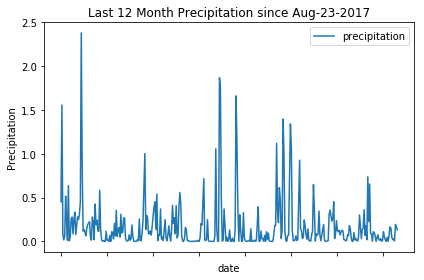

In [36]:
prcp_ave_df.plot(x='date', y='precipitation', title='Last 12 Month Precipitation since Aug-23-2017', use_index=True)
prcp_ave_df.set_index('date', inplace=True)
plt.ylabel("Precipitation")
plt.tight_layout()
plt.show()

In [37]:
# Calculate the total number of stations

session.query(func.count(Station.station)).all()

[(9)]

In [38]:
# Find the most active stations.  List stations and observation counts in descending order.

sel = [Measurement.station, 
      Measurement.tobs]

active_stations = session.query(*sel).\
    group_by(Measurement.station).\
    order_by(desc(Measurement.station)).all()

active_stations

[('USC00519523', 82.0),
 ('USC00519397', 81.0),
 ('USC00519281', 79.0),
 ('USC00518838', 74.0),
 ('USC00517948', 80.0),
 ('USC00516128', 76.0),
 ('USC00514830', 82.0),
 ('USC00513117', 77.0),
 ('USC00511918', 64.0)]

In [39]:
# Which station has the highest number of observations?
# USC00519523 with 82 observations.

In [40]:
# Retrieve the last 12 months of temperature observation data (tobs).
# Filter by the station with the highest number of observations.

sel = [Measurement.station, 
       Measurement.tobs,
      func.count(Measurement.tobs)]

past_year_tobs = session.query(*sel).\
    filter(Measurement.date >= qsdate, Measurement.date <= qedate).\
    group_by(Measurement.station).\
    order_by(Measurement.tobs).all()

In [22]:
past_year_tobs

[('USC00516128', 76.0, 328),
 ('USC00513117', 77.0, 343),
 ('USC00519281', 79.0, 352),
 ('USC00517948', 80.0, 60),
 ('USC00519397', 81.0, 359),
 ('USC00514830', 82.0, 265),
 ('USC00519523', 82.0, 314)]

In [41]:
# Save past year temperature observations results in a data frame
tobs_df = pd.DataFrame(past_year_tobs, columns=['station', 'tobs', 'Frequency'])
tobs_df.head()

,station,tobs,Frequency
0,USC00516128,76.0,328
1,USC00513117,77.0,343
2,USC00519281,79.0,352
3,USC00517948,80.0,60
4,USC00519397,81.0,359


Text(0,0.5,'Frequency')

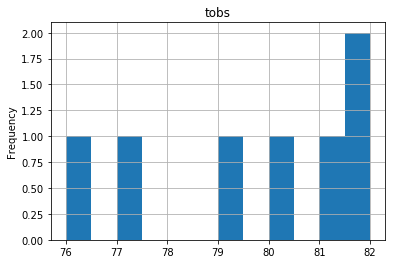

In [42]:
# Plot the results as a histogram with bins=12

tobs_df.hist(column='tobs', bins=12)
plt.ylabel("Frequency")


In [43]:
#Temperature Analysis

#Use the average temperature as the bar height.
#Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr).

In [44]:
#Write a function called calc_temps that will accept a start date and end date in the format %Y-%m-%d 
# and return the minimum, average, and maximum temperatures for that range of dates.
#Use the calc_temps function to calculate the min, avg, and max temperatures for your trip using the 
# matching dates from the previous year (i.e. use "2017-01-01" if your trip start date was "2018-01-01")

def calc_temps(ly_start_date, ly_end_date):
   
    sel = [Measurement.date,
          func.min(Measurement.tobs),
          func.avg(Measurement.tobs),
          func.max(Measurement.tobs)]

    ltobs_calc = session.query(*sel).\
    filter(Measurement.date >= ly_start_date, Measurement.date <= ly_end_date).\
    group_by(Measurement.date).\
    order_by(Measurement.date).all()
    
    return ltobs_calc

In [45]:
start_date = input('Enter start date (i.e. 2017-7-1)')
end_date = input('Enter end date (i.e. 2017-7-31)')

# Parse out just the year, month, and day from the datetime object
syear, smonth, sday = map(int, start_date.split('-'))
eyear, emonth, eday = map(int, end_date.split('-'))
    
ly_start_date = dt.date(syear, smonth, sday) - dt.timedelta(days=365)
ly_end_date = dt.date(eyear, emonth, eday) - dt.timedelta(days=365)   
    
tobs_calc = calc_temps(ly_start_date, ly_end_date)

Enter start date (i.e. 2017-7-1)2011-4-23
Enter end date (i.e. 2017-7-31)2011-4-30


In [46]:
print (tobs_calc)

[('2010-04-23', 66.0, 70.42857142857143, 75.0), ('2010-04-24', 69.0, 74.125, 77.0), ('2010-04-25', 73.0, 75.625, 78.0), ('2010-04-26', 67.0, 72.25, 76.0), ('2010-04-27', 69.0, 72.33333333333333, 75.0), ('2010-04-28', 70.0, 72.85714285714286, 76.0), ('2010-04-29', 69.0, 71.83333333333333, 74.0), ('2010-04-30', 69.0, 72.85714285714286, 77.0)]


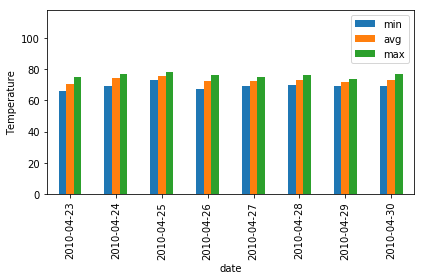

In [47]:
#Plot the min, avg, and max temperature from your previous query as a bar chart.

tobs_df = pd.DataFrame(tobs_calc, columns=['date', 'min', 'avg', 'max'])
tobs_df.set_index('date', inplace=True)
tobs_df.plot.bar()
plt.ylim(0, max(tobs_df['max']) + 40)
plt.ylabel("Temperature")
plt.tight_layout()
plt.show()

In [48]:
# Calculate the max-min peak-to-peak (PTP) values for temperatures observed
# Use numpy's ravel method to unpack the query's list of tuples into a list of PTP values.  
# list comprehension can also be used.

results = tobs_df['max'] - tobs_df['min']
ptps = list(np.ravel(results))

In [49]:
ptps

[9.0, 8.0, 5.0, 9.0, 6.0, 6.0, 5.0, 8.0]

C:\Users\DCPC\Anaconda3\envs\PythonData2\lib\site-packages\matplotlib\figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


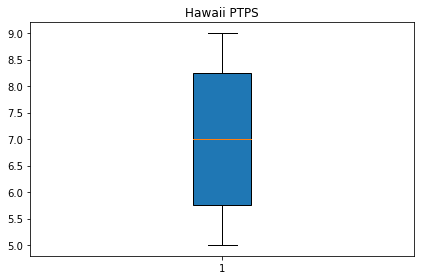

In [50]:
# Use matplotlib to plot the PTP values as a boxplot.

fig, ax = plt.subplots()
x = range(len(ptps))
ax.boxplot(ptps, patch_artist=True)
ax.set_title('Hawaii PTPS')
fig.tight_layout()
fig.show()